# R script

*** 

## 1. Load files

In [1]:
# Human lncRNA GENCODE v30 information
lncRNA <- read.csv('../01_Resources/References/gencode.v30.lncRNA_transcripts_major_compact.txt',sep = '\t',header = T) #16153
# Modify ensebl gene id of lncRNA
lncRNA[1] <- apply(lncRNA[1],1,function(x) {strsplit(x, split='.', fixed=TRUE)[[1]][1]})

# Three raw datasets
lncATLAs <- read.csv('../01_Resources/Resources/2021-01-29_lncATLAS_noncoding_data_RCI.tsv',sep = '\t', header = T) # 15929 ncRNAs * 15 = 238935
APEX = read.csv('../01_Resources/Resources/2019_CELL_APEXSeq.tsv',sep ='\t', header = T) # 3335 RNAs
Cefra = read.csv('../01_Resources/Resources/2018_CeFra_Seq_polyA_plus.tsv',sep = '\t',header = T) # 63677 RNAs

*** 

## 2. Data processing

- lncATLAS

In [5]:
# Reshape to format, col:cell lines; row: gene
lncATLAs <- na.omit(lncATLAs)
# 6768 lncRNAs with at least 1 RCI across 15 cellines
lncATLAs_reshape <- reshape(lncATLAs[,c(1,2,4)],v.names = 'Value',idvar = 'ENSEMBL.ID',timevar = 'Data.Source',direction = 'wide')
rownames(lncATLAs_reshape) <- lncATLAs_reshape[,1]
lncATLAs_reshape <- lncATLAs_reshape[,-1]

In [6]:
head(lncATLAs_reshape)

,Value.MCF.7,Value.A549,Value.GM12878,Value.H1.hESC,Value.HeLa.S3,Value.HepG2,Value.HT1080,Value.HUVEC,Value.IMR.90,Value.K562,Value.NCI.H460,Value.NHEK,Value.SK.MEL.5,Value.SK.N.DZ,Value.SK.N.SH
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000082929,1.23491,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000093100,-2.52324,-3.15798,-2.00351,-2.218200,-2.05661,-2.93963000,-2.53315,-2.64088,-3.17702,-1.871240,-1.92943,-2.4176300,-1.861310,-1.49035,-3.98660
ENSG00000099869,NA,NA,NA,1.000000,NA,0.00846158,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000100181,NA,NA,NA,-0.192645,NA,NA,NA,-1.01879,NA,-0.404775,NA,0.0238308,-0.161441,NA,NA
ENSG00000116652,-4.88753,-1.84800,-3.42824,1.652080,NA,-4.42626000,NA,NA,NA,NA,-4.98868,-2.9798200,NA,NA,NA
ENSG00000116883,-4.22716,-3.03986,NA,-1.841430,NA,-4.23810000,NA,-4.46698,-4.87990,-2.258520,-3.67007,-4.4907600,NA,NA,-5.17126


In [7]:
# Reshape to format, col:cell lines; row: gene
lncATLAs <- na.omit(lncATLAs)
# 6768 lncRNAs with at least 1 RCI across 15 cellines
lncATLAs_reshape <- reshape(lncATLAs[,c(1,2,4)],v.names = 'Value',idvar = 'ENSEMBL.ID',timevar = 'Data.Source',direction = 'wide')
rownames(lncATLAs_reshape) <- lncATLAs_reshape[,1]
lncATLAs_reshape <- lncATLAs_reshape[,-1]

# Remove RCI value in H1 cell line since the discordance
lncATLAs_reshape <- lncATLAs_reshape[,-4]
# Calculate the average RCI across cell lines for each lncRNA
mean_NAomit <- function(x) {
  RCIsum = count = 0
  for(i in na.omit(x)) {
      RCIsum <- RCIsum+i 
      count <- count+1
  }
  return(RCIsum/count)
} 

RCI_mean <- as.data.frame(apply(lncATLAs_reshape,1,mean_NAomit))
ensembl_gene_id <- row.names(RCI_mean)
RCI_mean <- as.data.frame(cbind(ensembl_gene_id,RCI_mean));
colnames(RCI_mean) <- c('ensembl_gene_id','RCI_mean')
# 5760 lncRNAs with at least 1 RCI across 14 cellines
RCI_mean <- na.omit(RCI_mean) # 5760


lncATLAS_Nuc <- as.character(RCI_mean[which(RCI_mean$RCI_mean < -2),'ensembl_gene_id']) # 1983
lncATLAS_Cyto <- as.character(RCI_mean[which(RCI_mean$RCI_mean > 0),'ensembl_gene_id']) # 1525

In [8]:
nrow(lncATLAs_reshape)

[1] 6768

In [9]:
nrow(RCI_mean)

[1] 5760

In [10]:
length(lncATLAS_Nuc)

[1] 1983

In [11]:
length(lncATLAS_Cyto)

[1] 1525

*** 

### 

- APEX-Seq

In [17]:
# Select human lncRNAs 
APEX = APEX[which(APEX$Ensembl_Gene %in% lncRNA$ensembl_gene_id),] #61

# For APEX (as mentioned in the original article, log fd > 0.75 is considered for enrichment)
# Collapsed 8 loc into binary loc
Nuc=vector(); Cyto=vector()
for (i in c(1:nrow(APEX))) {
  if (APEX[i,'Nucleus_log2FC']>0.75) {Nuc[i] = 1}
  else if (APEX[i,'Nucleolus_log2FC']>0.75) {Nuc[i] = 1}
  else if (APEX[i,'Lamina_log2FC']>0.75) {Nuc[i] = 1}
  else if (APEX[i,'Nuclear_Pore_log2FC']>0.75) {Nuc[i] = 1}
  else {Nuc[i] = 0}
  if (APEX[i,'Cytosol_log2FC']>0.75) {Cyto[i] = 1}
  else if (APEX[i,'ERM_log2FC']>0.75) {Cyto[i] = 1}
  else if (APEX[i,'OMM_log2FC']>0.75) {Cyto[i] = 1}
  else if (APEX[i,'ER_Lumen_log2FC']>0.75) {Cyto[i] = 1}
  else {Cyto[i] = 0}
}
APEX_loc <- as.data.frame(cbind(APEX,Nuc,Cyto)) # 61
APEX_Nuc <- as.character(APEX_loc[which(APEX_loc$Nuc == 1 & APEX_loc$Cyto == 0),'Ensembl_Gene']) # 42 of 56
APEX_Cyto <- as.character(APEX_loc[which(APEX_loc$Nuc == 0 & APEX_loc$Cyto == 1),'Ensembl_Gene']) # 5 of 19

In [18]:
nrow(APEX)

[1] 61

In [19]:
length(APEX_Nuc)

[1] 42

In [20]:
length(APEX_Cyto)

[1] 5

*** 

### 

- Cefra-Seq

In [21]:
# 14746 lncRNAs
Cefra <- Cefra[which(Cefra$gene_biotype %in% c('antisense','sense_intronic','lincRNA','processed_transcript')),]

ExpressedRNA <- function(cyto_A,cyto_B,insol_A,insol_B,membr_A,membr_B,nucl_A,nucl_B){
  exp_cyto <- (cyto_A+cyto_B)/2; exp_insol = (insol_A+insol_B)/2
  exp_membr <- (membr_A+membr_B)/2; exp_nucl = (nucl_A+nucl_B)/2
  if (exp_cyto >=1|exp_insol>=1|exp_membr>=1|exp_nucl>=1) {expressed <- 1} else{expressed <- 0}
  if (expressed == 1) {CNRCI <- max(exp_cyto,exp_insol,exp_membr)/(max(exp_cyto,exp_insol,exp_membr)+exp_nucl)} else{CNRCI<-0}
  return(list(expressed = expressed,CNRCI = CNRCI))
}

expressed = vector(); CNRCI= vector()
for (i in c(1:nrow(Cefra))) {
  result <- ExpressedRNA(Cefra[i,'cyto_A'],Cefra[i,'cyto_B'],Cefra[i,'insol_A'],Cefra[i,'insol_B'],
               Cefra[i,'membr_A'],Cefra[i,'membr_B'],Cefra[i,'nucl_A'],Cefra[i,'nucl_B'])
  expressed[i] <- result$expressed; CNRCI[i] <- result$CNRCI
}

Cefra_high <- Cefra[which(expressed == 1),] # 1621 lncRNAs with high expression
CN_RCI_high <- as.data.frame(unlist(CNRCI[which(expressed == 1)]))
colnames(CN_RCI_high) <- "CN_RCI"
Cefra_high <- as.data.frame(cbind(Cefra_high,CN_RCI_high))

Cefra_Nuc = as.character(Cefra_high[which(Cefra_high$CN_RCI<0.4),'ensembl_gene_id']) # 528
Cefra_Cyto = as.character(Cefra_high[which(Cefra_high$CN_RCI>0.6),'ensembl_gene_id']) # 916

In [22]:
nrow(Cefra)

[1] 14746

In [23]:
nrow(Cefra_high)

[1] 1621

In [24]:
length(Cefra_Nuc)

[1] 528

In [25]:
length(Cefra_Cyto)

[1] 916

*** 

###    

## 3. Union and remove bi-localized lncRNAs 

In [26]:
# Union
Nuc_Union <- union(union(APEX_Nuc,Cefra_Nuc),lncATLAS_Nuc)
Cyto_Union <- union(union(APEX_Cyto,Cefra_Cyto),lncATLAS_Cyto)

In [27]:
# Remove bi-localized lncRNAs
Nuc_final <- as.data.frame(setdiff(Nuc_Union,Cyto_Union))
Cyto_final <- as.data.frame(setdiff(Cyto_Union,Nuc_Union))
colnames(Nuc_final) = colnames(Cyto_final) = 'ensembl_gene_id'

In [28]:
nrow(Nuc_final)

[1] 2185

In [29]:
nrow(Cyto_final)

[1] 1940

*** 

###    

## 4. Filter by GENCODE annotation

In [30]:
Nuc_info <- merge.data.frame(lncRNA,Nuc_final,by = 'ensembl_gene_id')
Cyto_info <- merge.data.frame(lncRNA,Cyto_final,by = 'ensembl_gene_id')

In [31]:
nrow(Nuc_info)

[1] 1986

In [32]:
nrow(Cyto_info)

[1] 1806

*** 

###    

## 5. Output

In [67]:
write.table(Nuc_info,'01_lncRNA_info_nuc_gene.tsv',sep ='\t', quote = FALSE,row.names = FALSE)
write.table(Cyto_info,'01_lncRNA_info_cyto_gene.tsv',sep = '\t', quote = FALSE,row.names = FALSE)

In [68]:
# Summary of sequence length
total <- rbind(Nuc_info,Cyto_info)
quantile(tapply(as.character(total$cdna),total$ensembl_gene_id,nchar),c(0,0.05,0.25,0.50,0.75,0.95,1))

0%        5%       25%       50%       75%       95%      100% 
    68.00    382.55    562.00    852.00   1937.00   3825.25 205012.00

In [10]:
total$length <- tapply(as.character(total$cdna),total$ensembl_gene_id,nchar)

In [11]:
library(ggplot2)

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”


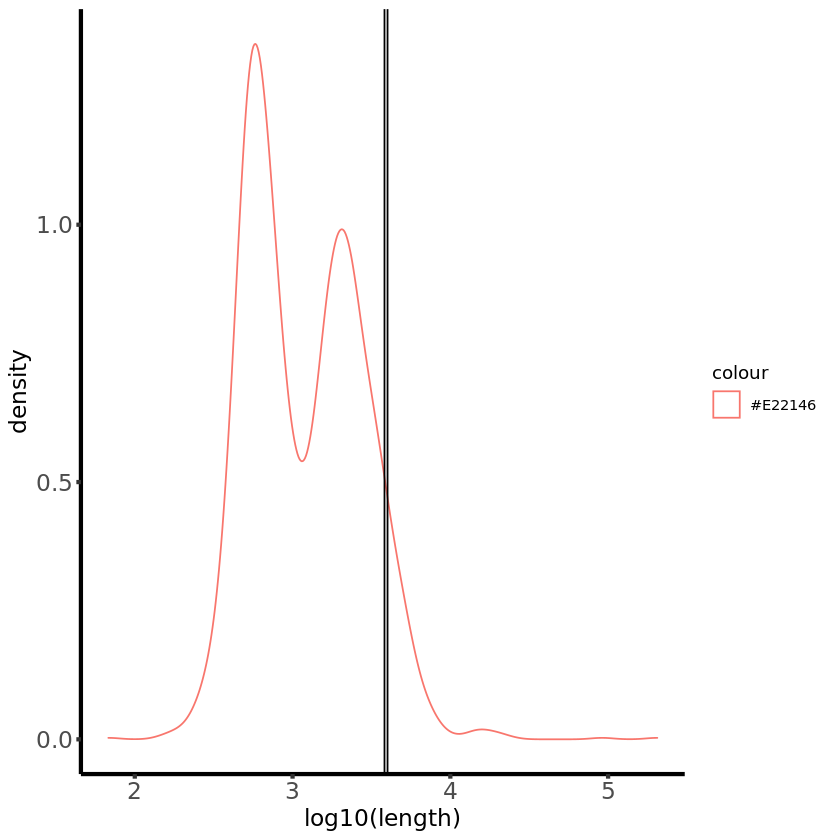

In [27]:
p_dis<- ggplot(total, aes(x=log10(length),color = "#E22146"))+
geom_density()+
geom_vline(xintercept = log10(3825.25))+
geom_vline(xintercept = log10(4000))+
theme_classic()+
theme(axis.text = element_text(size=14),
      axis.title = element_text(size=14),
      element_line(size = 1.2))
ggsave("./01_lncRNA_length_distribution_with_text.pdf", p_dis, width = 10, height = 10) 
p_dis

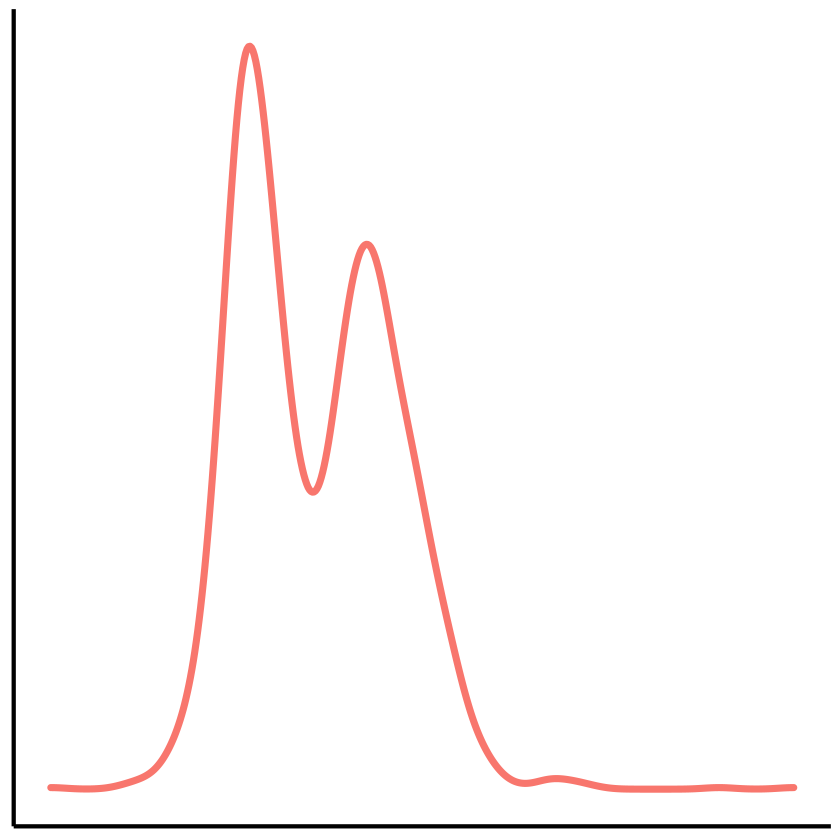

In [29]:
p_dis_blank <- ggplot(total, aes(x=log10(length),color = "#E22146"))+
geom_density(size = 2)+
theme_classic()+
theme(axis.text = element_text(size=14),
      axis.title = element_text(size=14),
      element_line(size = 1.2))+
theme(axis.text = element_blank(),axis.title = element_blank(),axis.ticks = element_blank(),legend.position = "None")
ggsave("./01_lncRNA_length_distribution.pdf", p_dis_blank, width = 10, height = 10) 
p_dis_blank